In [1]:
from tqdm import tqdm
import pickle
import pandas as pd
from pathlib import Path
import numpy as np
import scipy
import copy
import sys
import os
from typing import Optional, Union, Sequence, Mapping, List, Set
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import cm
from matplotlib.lines import Line2D
import warnings
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics.pairwise import cosine_similarity,cosine_distances
from scipy.stats import sem

sys.path.append('/mnt/c/Users/lslat/Code/')
sys.path.append('/mnt/c/Users/lslat/QiskitProjects/VariationalWavefunction/')

from quantum_kernel.code.utils import get_dataset
from quantum_kernel.code.visualization_utils import aggregate_shapes,filter_df
from quantum_kernel.code.kernel_measures.kernel_geometry import purity_average, purity_of_average,geometric_difference,geometric_distance
from quantum_kernel.code.kernel_measures.eigenvalue_scaling import get_eigenvalue_scaling,compute_dataframe_kernel_eigenvalues

font = {'family': 'DejaVu Sans',
        'weight': 'bold',
        'size': 30}

rc('font', **font)

tqdm.pandas()
warnings.filterwarnings("ignore")


In [2]:
# Get kernel results for the different ml models and dataset.d
dfs = {}
betas=[1.0]
alphas=[2.0]
gammas=[0.3]
folders = [
    ("/mnt/c/Users/lslat/Data/QK_project/results/HZZ_multi/final_gennorm/matrix_size_test/beta{}/alpha{}/gamma{}/".format(betas[0],alphas[0],gammas[0]),'HZZ_Multi'),
    ("/mnt/c/Users/lslat/Data/QK_project/results/HZZ_multi/final_gennorm/matrix_size_test/beta{}/alpha{}/".format(betas[0],alphas[0]),'HZZ_Multi'),
]

cols_to_drop=['args', 'K_train_time', 'rdms', 
'samples', 'mu','sigma', 'outpath', 'projected']

def get_dfs_from_folder(folder,prefix,cols_to_drop):
    dfs={}
    dfs[prefix] = aggregate_shapes(folder,prefix,cols_to_drop=cols_to_drop)
    return dfs

dfs_list=[get_dfs_from_folder(folder[0],folder[1],cols_to_drop) for folder in folders]

In [3]:
save_folder='/mnt/c/Users/lslat/Data/QK_project/results/figs/'

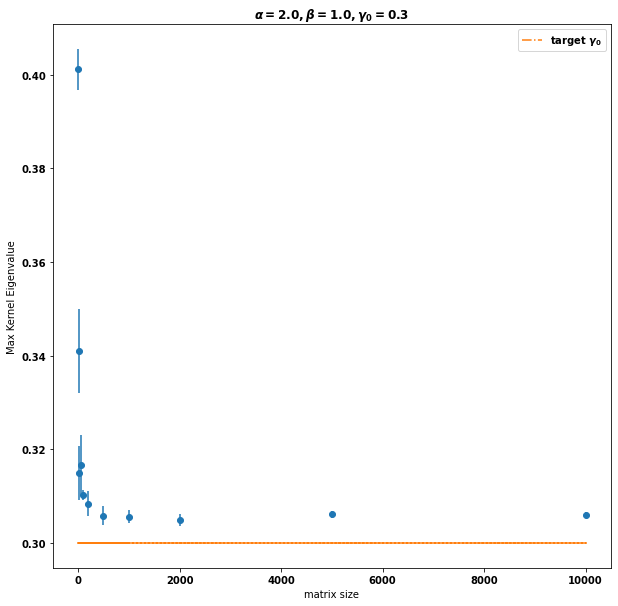

In [4]:
beta=1.0
alpha=2.0
gamma=0.3
fig, axs = plt.subplots(1,figsize=(10,10))
ax=axs
ax.set_ylabel('Max Kernel Eigenvalue')
dfs=dfs_list[0]
iqp_df=dfs['HZZ_Multi']
filter={'beta': beta,'alpha':alpha,'h_layer':1,'dataset_dim':12}
target_iqp_df=filter_df(iqp_df,filter)
xp=list(set(target_iqp_df.matrix_size.values))
yp=[np.mean(target_iqp_df[target_iqp_df.matrix_size==x].apply(lambda x: max(x.kernel_eigenvalues),axis=1).values) for x in xp]
yerr=[sem(target_iqp_df[target_iqp_df.matrix_size==x].apply(lambda x: max(x.kernel_eigenvalues),axis=1).values) for x in xp]

ax.errorbar(xp,yp,yerr=yerr,fmt='o',ls='')
ax.set_xlabel('matrix size')
ax.set_title(rf'$\alpha={alpha}, \beta={beta}, \gamma_{0}={gamma}$',color='black')

ax.plot(xp,len(xp)*[gamma],ls='-.',label=r'target $\gamma_{0}$')
ax.legend()
#fig.savefig(f'{save_folder}IQP_max_eigval_v_dim_fixed_beta{beta}.png')

In [5]:
matrix_sizes=set(target_iqp_df.matrix_size.values)
seeds = set(target_iqp_df.seed.values)

beta=1.0
alpha=2.0
gamma=0.3
dim=12

folder="/mnt/c/Users/lslat/Data/QK_project/results/HZZ_multi/final_gennorm/"
subfolder=f"matrix_size_test/beta{beta}/alpha{alpha}/"

filepath=save_folder+f'geometric_difference_dict_ms_test_beta{beta}_alpha{alpha}_gamma_{gamma}.p'
if os.path.exists(filepath):
    with open(filepath, 'rb') as pickle_file:
        geo_diffs=pickle.load(pickle_file)
else:
    geo_diffs={}
    dfs=dfs_list[0]
    iqp_df=dfs['HZZ_Multi']
    filter={'beta': beta,'alpha':alpha,'h_layer':1,'dataset_dim':dim}
    target_iqp_df=filter_df(iqp_df,filter)

    for ms in matrix_sizes:
        print(f'on matrix size: {ms}')
        prefix=f"HZZ_Multi_dim_{dim}*hlayer_0"

        dfs=get_dfs_from_folder(folder+subfolder,prefix,cols_to_drop)
        generic_ciqp_df=dfs[prefix]

        geo_diffs[str(ms)]=[]
        for seed in seeds:
            c_df=generic_ciqp_df[(generic_ciqp_df['seed']==seed) & (generic_ciqp_df['matrix_size']==ms) & (generic_ciqp_df['dataset_dim']==dim)]
            q_df=target_iqp_df[(target_iqp_df['matrix_size']==ms) & (target_iqp_df['seed']==seed)]
            Kq=q_df.qkern_matrix_train.values[0]
            Kcs=c_df.qkern_matrix_train.values
            sfs=c_df.scaling_factor.values
            geo_diffs[str(ms)]=geo_diffs[str(ms)]+[(sf,geometric_difference(Kq,Kc)) for sf,Kc in zip(sfs,Kcs)]
        geo_diffs[str(ms)]=np.array(geo_diffs[str(ms)])

    with open(filepath, 'wb') as f:
        try:
            pickle.dump(geo_diffs,f)
        except:
            print('Could not save geo_diffs dictionary')

on matrix size: 100
on matrix size: 5
on matrix size: 1000
on matrix size: 200
on matrix size: 10
on matrix size: 5000
on matrix size: 10000
on matrix size: 2000
on matrix size: 50
on matrix size: 20
on matrix size: 500


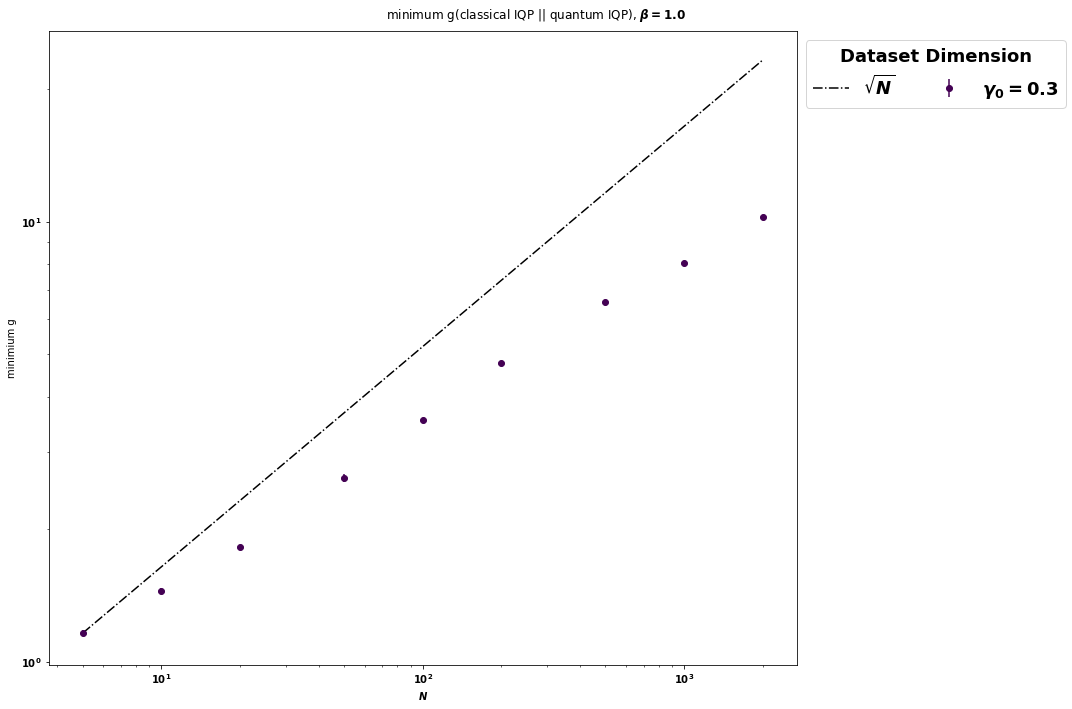

In [15]:
colormap=cm.viridis
#matrix_sizes=np.array(list(set(target_iqp_df.matrix_size.values)))
#matrix_sizes.sort()
matrix_sizes=np.array([5, 10, 20, 50, 100, 200, 500, 1000, 2000])
seeds = set(target_iqp_df.seed.values)

beta=1.0
alpha=2.0
gamma=0.3
dim=12

fig, axs = plt.subplots(1,figsize=(15,10),sharey=True)

filepath=save_folder+f'geometric_difference_dict_ms_test_beta{beta}_alpha{alpha}_gamma_{gamma}.p'
if os.path.exists(filepath):
    with open(filepath, 'rb') as pickle_file:
        geo_diffs=pickle.load(pickle_file)
else:
    pass
ax=axs

color_index=0
color=colormap.colors[color_index]
    
ys=[]
yerrs=[]
for ms in matrix_sizes:
    x=list(set(geo_diffs[str(ms)][:,0]))
    y=min([np.mean(geo_diffs[str(ms)][geo_diffs[str(ms)][:,0]==a][:,1]) for a in x])
    index = [np.mean(geo_diffs[str(ms)][geo_diffs[str(ms)][:,0]==a][:,1]) for a in x].index(y)
    yerr=[sem(geo_diffs[str(ms)][geo_diffs[str(ms)][:,0]==a][:,1]) for a in x][index]

    ys.append(y)
    yerrs.append(yerr)
ax.errorbar(list(matrix_sizes),ys,yerr=yerrs,color=color,fmt='o',label=rf'$\gamma_0={gamma}$')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('minimium g')
ax.set_xlabel('$N$')

ax.plot(matrix_sizes,ys[0]*np.sqrt(matrix_sizes/matrix_sizes[0]),ls='-.',color='black',label=r'$\sqrt{N}$')


legend=plt.legend(ncol=2,bbox_to_anchor=(1,1),fontsize=18,title_fontsize=18)
legend.set_title('Dataset Dimension')

fig.suptitle(rf'minimum g(classical IQP || quantum IQP), $\beta={beta}$')

fig.tight_layout()
#fig.savefig(f'{save_folder}IQP_gd_decay_fixed_beta{beta}.png')